In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from synthpop import MissingDataHandler, DataProcessor, GaussianCopulaMethod
from synthpop.metrics import (
    MetricsReport,
    EfficacyMetrics,
    DisclosureProtection
)
import matplotlib.pyplot as plt
from helper_functions import *
from matplotlib.colors import LinearSegmentedColormap
warnings.filterwarnings('ignore')

### Load data and prepare data

In [2]:
df = pd.read_csv('../../datasets/social diagnosis/SocialDiagnosis2011.csv', delimiter=';', index_col=False)
print(df.shape)
print(df.columns)
display(df.head())

(5000, 6)
Index(['sex', 'age', 'marital', 'income', 'ls', 'smoke'], dtype='object')


,sex,age,marital,income,ls,smoke
0,FEMALE,57,MARRIED,800.0,PLEASED,NO
1,MALE,20,SINGLE,350.0,MOSTLY SATISFIED,NO
2,FEMALE,18,SINGLE,NaN,PLEASED,NO
3,FEMALE,78,WIDOWED,900.0,MIXED,NO
4,FEMALE,54,MARRIED,1500.0,MOSTLY SATISFIED,YES


**UI text #1**

The [Social Diagnosis 2011*](https://search.r-project.org/CRAN/refmans/synthpop/html/SD2011.html) dataset is used as a demo. Synthetic data will be generated for the following columns: 

- sex: sex of a person
- age: age of a person
- marital: marital status
- income: personal monthly net income
- ls: perception of life as a whole
- smoke: smoking cigarettes

Gaussian Copula will be used to evaluate the distribution and correlation differences between the real and synthetic data.

*The original paper can be found [here](https://ce.vizja.pl/en/issues/volume/5/issue/3#art254).

### 0. Preview of data

In [3]:
# dataset
df.head()

,sex,age,marital,income,ls,smoke
0,FEMALE,57,MARRIED,800.0,PLEASED,NO
1,MALE,20,SINGLE,350.0,MOSTLY SATISFIED,NO
2,FEMALE,18,SINGLE,NaN,PLEASED,NO
3,FEMALE,78,WIDOWED,900.0,MIXED,NO
4,FEMALE,54,MARRIED,1500.0,MOSTLY SATISFIED,YES


In [4]:
print(df.isnull().sum())

sex          0
age          0
marital      9
income     683
ls           8
smoke       10
dtype: int64


### 1. Data types detection

**UI text #2**

The following data types are detected:

[output]

If the detected data types are incorrect, please change this locally in the source dataset before attaching it to the web app.

In [5]:
md_handler = MissingDataHandler()

# Check the data types
column_dtypes = md_handler.get_column_dtypes(df)
print("Column Data Types:", column_dtypes)

Column Data Types: {'sex': 'categorical', 'age': 'numerical', 'marital': 'categorical', 'income': 'numerical', 'ls': 'categorical', 'smoke': 'categorical'}


### 2. Handling missing data

**UI text #3**

For the following columns, the missing data type is:

{{ dynamic

- sex: MAR
- race1: MAR

}}

For Missing At Random (MAR) and Missing Not At Random (MNAR) data, we recommend to impute the missing data. For Missing Completely At Random (MCAR), we recommend to remove the missing data. See the info box for more information. [i]

[demo text] In this demo CART is used, the missing data is therefore imputed. When using Gaussian Copula, the user can choose whether the missing data is removed or imputed, depending on the type of missing data.

[i] _info box:_

MCAR, MAR, and MNAR are terms used to describe different mechanisms of missing data:

1. **MCAR (Missing Completely At Random)**:
- The probability of data being missing is completely independent of both observed and unobserved data. 
- There is no systematic pattern to the missingness.
- Example: A survey respondent accidentally skips a question due to a printing error.
- Recommendation: remove missing data.

2. **MAR (Missing At Random)**:
- The probability of data being missing is related to the observed data but not the missing data itself.
- The missingness can be predicted by other variables in the dataset.
- Example: Students' test scores are missing, but the missingness is related to their attendance records.
- Recommendation: impute missing data.

3. **MNAR (Missing Not At Random)**:
- The probability of data being missing is related to the missing data itself. 
- There is a systematic pattern to the missingness that is related to the unobserved data.
- Example: Patients with more severe symptoms are less likely to report their symptoms, leading to missing data that is related to the severity of the symptoms.
- Recommendation: impute missing data.

In [6]:
# Detect missingness
missingness_dict = md_handler.detect_missingness(df)
print("Detected Missingness Type:", missingness_dict)

Detected Missingness Type: {'marital': 'MAR', 'income': 'MAR', 'ls': 'MAR', 'smoke': 'MAR'}


In [7]:
real_df = md_handler.apply_imputation(df, missingness_dict)

print(real_df.isnull().sum())

sex        0
age        0
marital    0
income     0
ls         0
smoke      0
dtype: int64


### [no section] Pre-processing data

In [8]:
# Instantiate the DataProcessor with the metadata
metadata = column_dtypes
processor = DataProcessor(metadata)

# Preprocess the data: transforms raw data into a numerical format
processed_data = processor.preprocess(real_df)
print("Processed Data:")
display(processed_data.head())

Processed Data:


,sex,age,marital,income,ls,smoke
0,0,57.0,3,800.000000,4,0
1,1,20.0,4,350.000000,3,0
2,0,18.0,4,1411.093352,4,0
3,0,78.0,5,900.000000,1,0
4,0,54.0,3,1500.000000,3,1


### 3. Synthesized: Gaussian Copula

In [9]:
# Instantiate and fit the GC synthesized
GC = GaussianCopulaMethod(metadata)
GC.fit(processed_data)

INFO:copulas.multivariate.gaussian:Fitting GaussianMultivariate(distribution="{'sex': <class 'copulas.univariate.beta.BetaUnivariate'>, 'age': <class 'copulas.univariate.beta.BetaUnivariate'>, 'marital': <class 'copulas.univariate.beta.BetaUnivariate'>, 'income': <class 'copulas.univariate.beta.BetaUnivariate'>, 'ls': <class 'copulas.univariate.beta.BetaUnivariate'>, 'smoke': <class 'copulas.univariate.beta.BetaUnivariate'>}")


In [10]:
# For prediction, we might use the same data (or new preprocessed data)
synthetic_processed = GC.sample(5000)
print("Synthetic Processed Data (in numerical space):")
display(synthetic_processed.head())

Synthetic Processed Data (in numerical space):


,sex,age,marital,income,ls,smoke
0,0.752295,81.024336,2.087116,-6.908824,2.145658,0.000254
1,0.000035,28.607868,3.806609,7518.709032,5.235300,0.000254
2,0.717934,34.654175,3.322216,382.129345,2.525134,0.000254
3,0.036815,36.841385,5.218664,197.654440,3.553101,1.000000
4,0.000008,63.403562,4.301809,3558.178022,5.149001,0.000254


**UI text #4**

{n_synth_data} synthetic data points are generated using Gaussian copula (GC). 

GC works in two main steps:
1. The real data is transformed into a uniform distribution. Correlations between variables are modeled using a multivariate normal distribution (the *Gaussian copula*);
2. Synthetic data is created by sampling from this Gaussian copula and transforming the samples back to the original data distributions.

### [no section] Post-processing synthetic data

In [11]:
# Postprocess the synthetic data back to the original format
synthetic_df = processor.postprocess(synthetic_processed)
print("Synthetic Data in Original Format:")
display(synthetic_df.head())

Synthetic Data in Original Format:


,sex,age,marital,income,ls,smoke
0,MALE,81,LEGALLY SEPARATED,-6.908824,MOSTLY DISSATISFIED,NO
1,FEMALE,29,SINGLE,7518.709032,TERRIBLE,NO
2,MALE,35,MARRIED,382.129345,MOSTLY SATISFIED,NO
3,FEMALE,37,WIDOWED,197.654440,PLEASED,YES
4,FEMALE,63,SINGLE,3558.178022,TERRIBLE,NO


### 4. Evaluation of generated data

In [12]:
# combine original data and decoded synthetic data in dataframe
combined_data = pd.concat((real_df.assign(realOrSynthetic='real'), synthetic_df.assign(realOrSynthetic='synthetic')), keys=['real','synthetic'], names=['Data'])
combined_data

sex  age  marital       income                   ls smoke  \
Data                                                                           
real      0     FEMALE   57  MARRIED   800.000000              PLEASED    NO   
          1       MALE   20   SINGLE   350.000000     MOSTLY SATISFIED    NO   
          2     FEMALE   18   SINGLE  1411.093352              PLEASED    NO   
          3     FEMALE   78  WIDOWED   900.000000                MIXED    NO   
          4     FEMALE   54  MARRIED  1500.000000     MOSTLY SATISFIED   YES   
...                ...  ...      ...          ...                  ...   ...   
synthetic 4995    MALE   70  MARRIED   460.796501     MOSTLY SATISFIED    NO   
          4996  FEMALE   51   SINGLE    -2.287845     MOSTLY SATISFIED    NO   
          4997  FEMALE   49  MARRIED  3002.065815              PLEASED    NO   
          4998  FEMALE   47  WIDOWED  6632.134060  MOSTLY DISSATISFIED   YES   
          4999  FEMALE   34  WIDOWED   933.312456     MOSTLY SATISFIED    NO   

               realOrSynthetic  
Data                            
real      0               real  
          1               real  
          2               real  
          3               real  
          4               real  
...                        ...  
synthetic 4995       synthetic  
          4996       synthetic  
          4997       synthetic  
          4998       synthetic  
          4999       synthetic  

[10000 rows x 7 columns]

#### 4.1 Distributions

#### 4.1.1 Univariate distributions

**UI text #5**

{n_synth_data} synthetic data points are generated using CART. The figures below display the value frequency for each variable. The synthetic data is of high quality when the frequencies are approximately the same.

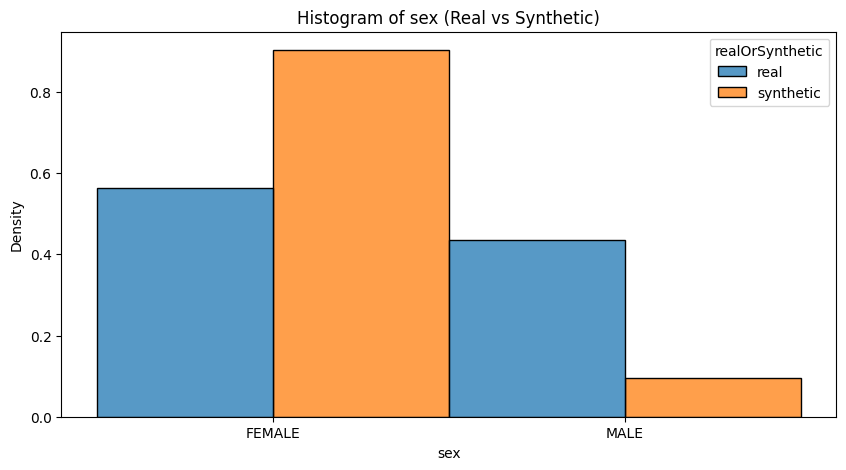

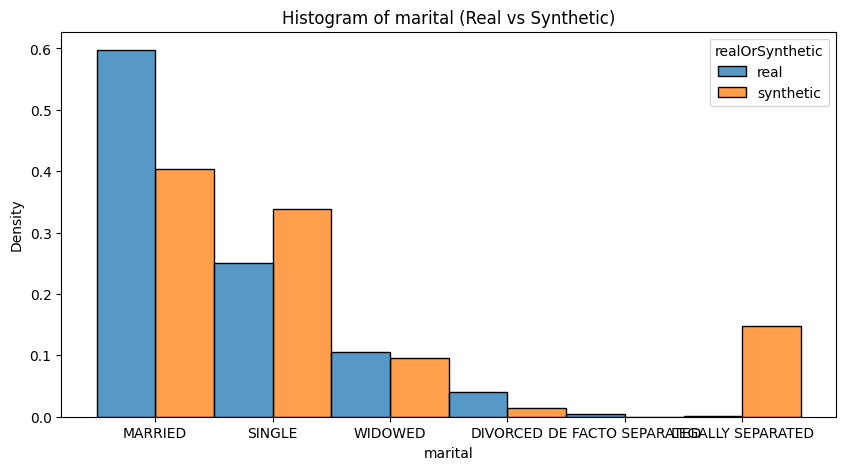

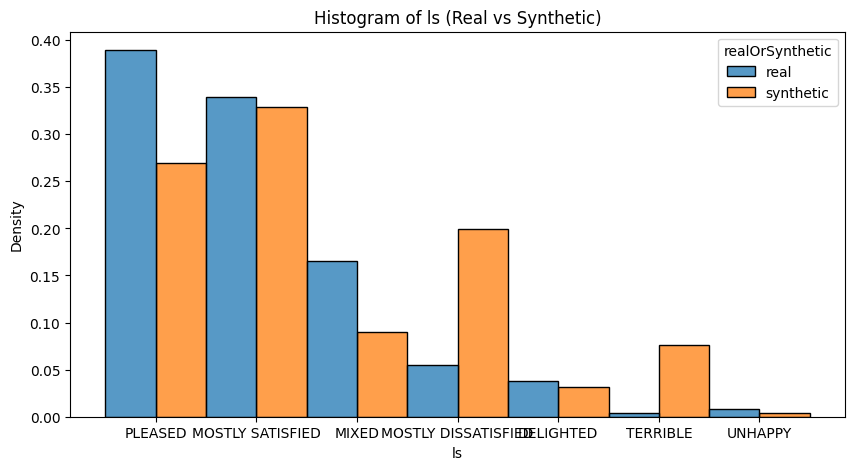

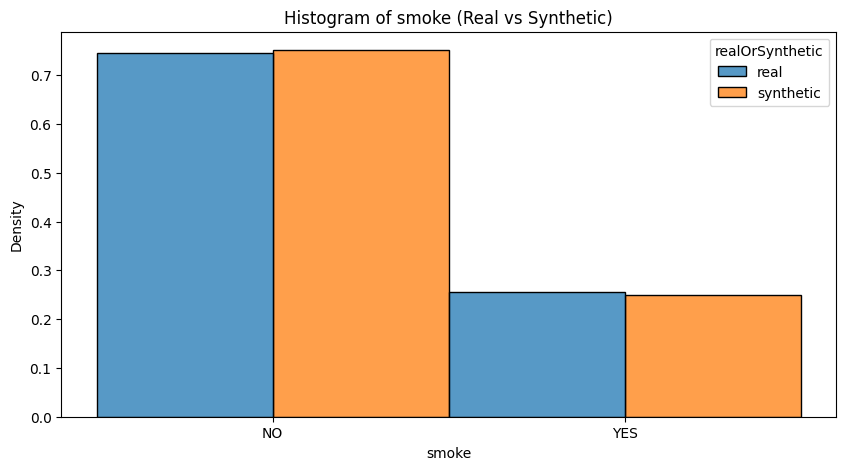

In [13]:
# Plot histograms for each column comparing real and synthetic data
for column in real_df.columns:
    if column_dtypes[column] != 'categorical':
        continue
    plt.figure(figsize=(10, 5))
    sns.histplot(data=combined_data, x=column, hue='realOrSynthetic', element='bars', stat='density', common_norm=False, multiple='dodge', binwidth=0.1)
    plt.title(f'Histogram of {column} (Real vs Synthetic)')
    plt.show()

##### 4.1.2 Bivariate distributions

**UI text #8**

The figures below display the differences in value frequency for a combination of variables. For comparing two categorical variables, bar charts are plotted. For comparing a numerical and a categorical variables, a so called [violin plot](https://en.wikipedia.org/wiki/Violin_plot) is shown. For comparing two numercial variables, a [LOESS plot](https://en.wikipedia.org/wiki/Local_regression) is created. For all plots holds: the synthetic data is of high quality when the shape of the distributions in the synthetic data equal the distributions in the real data.

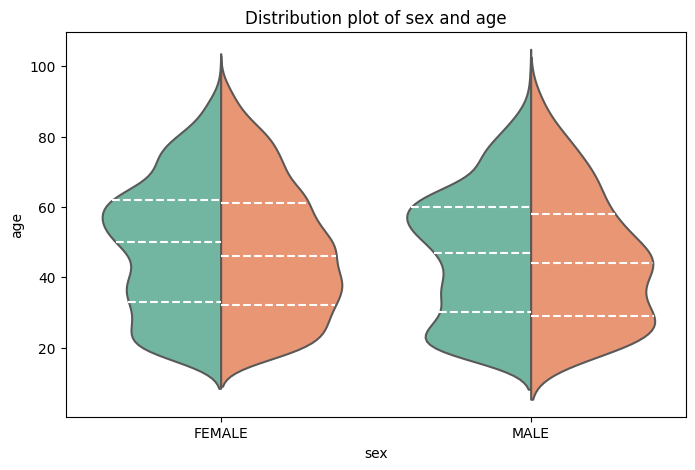

<Figure size 800x500 with 0 Axes>

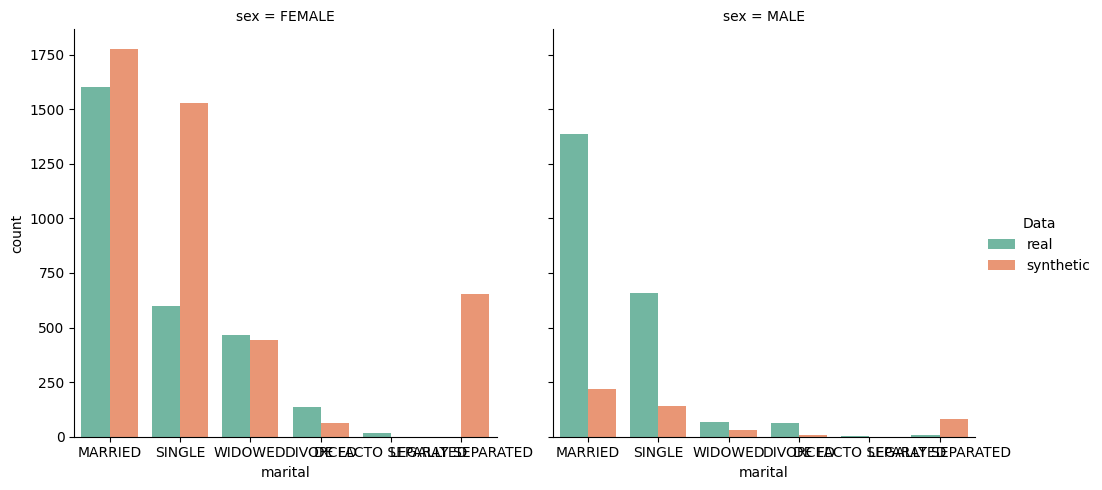

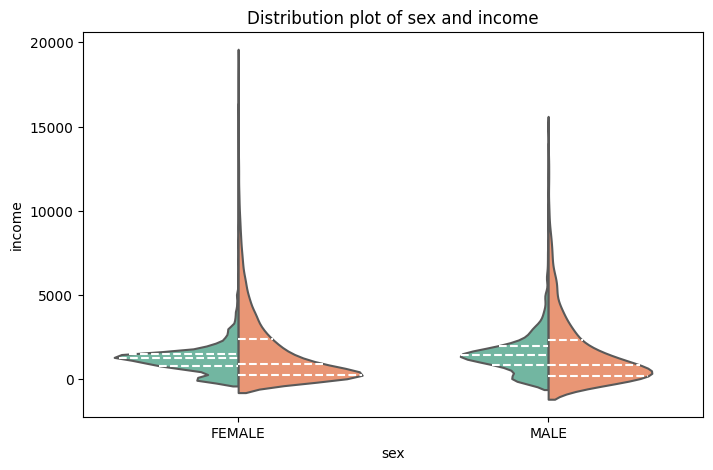

<Figure size 800x500 with 0 Axes>

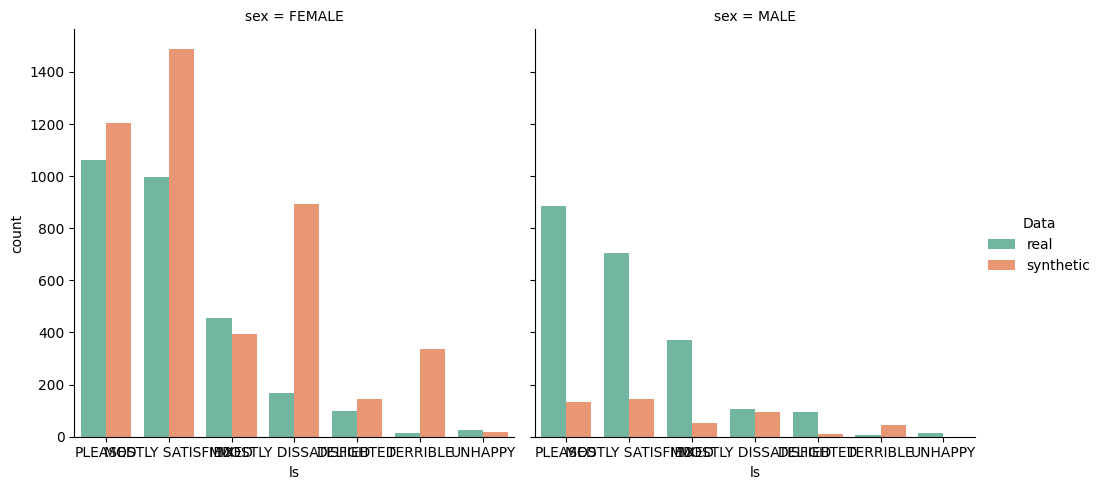

<Figure size 800x500 with 0 Axes>

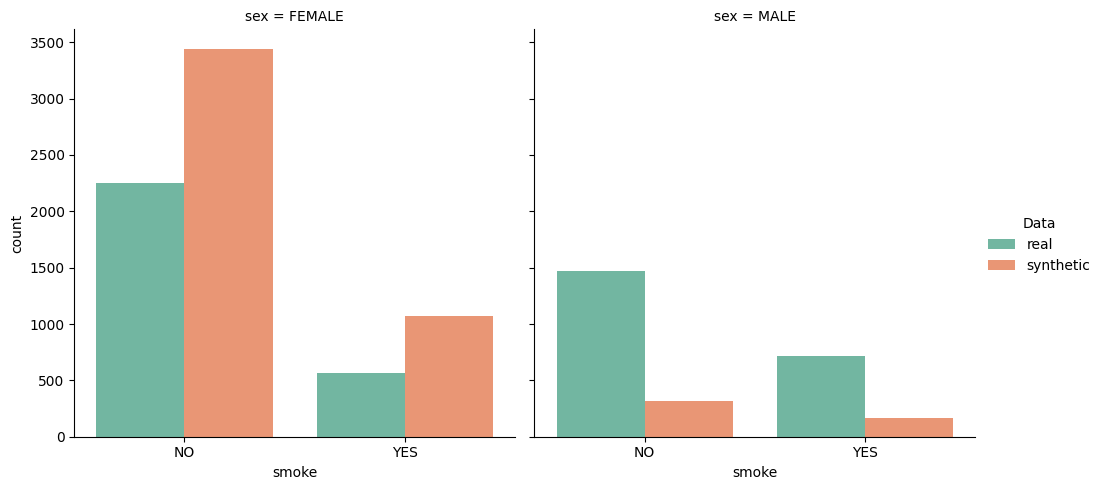

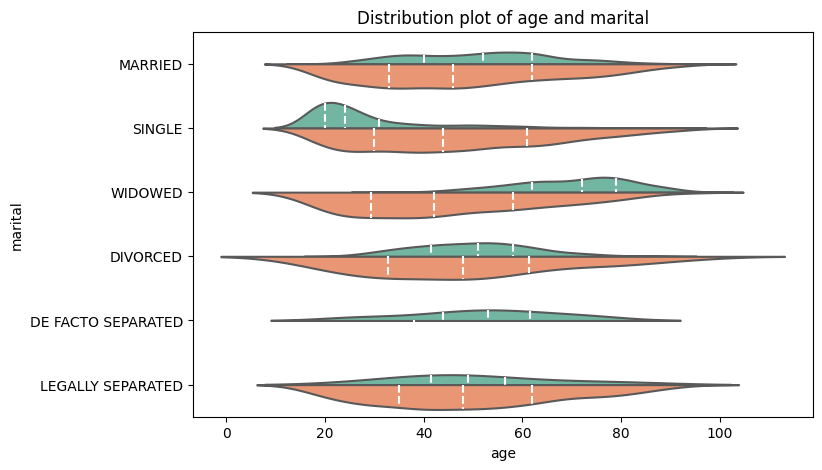

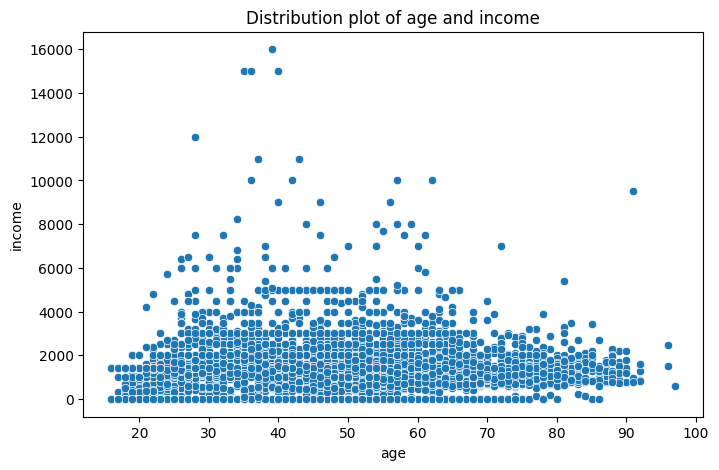

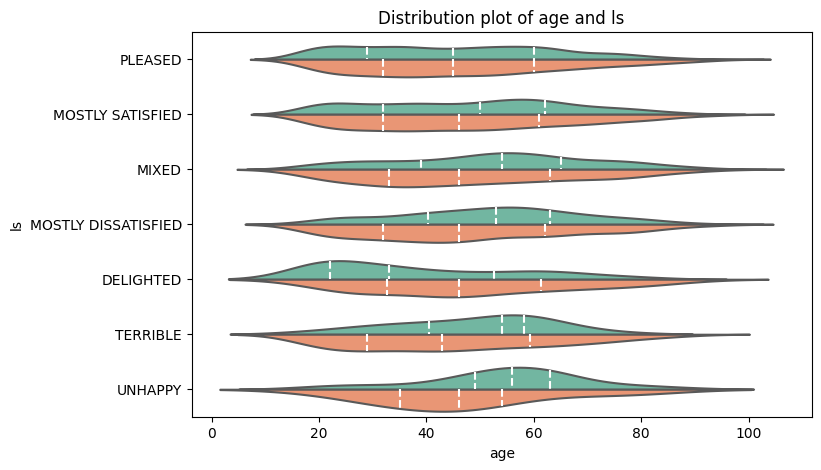

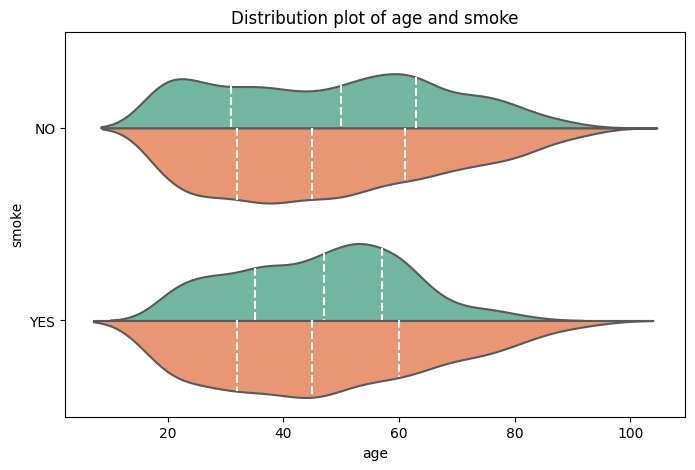

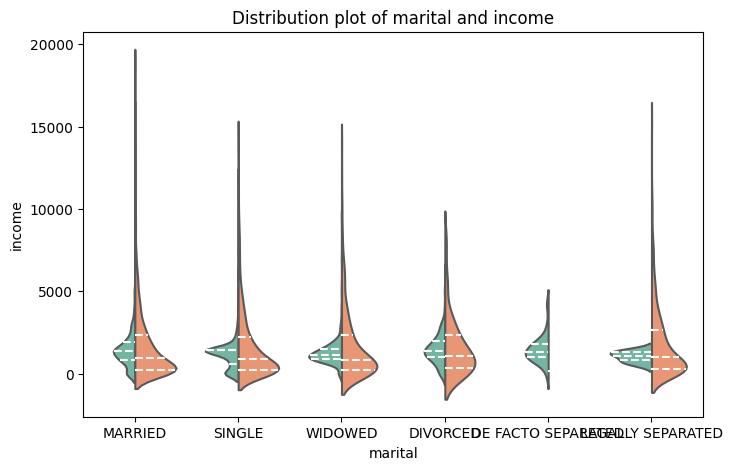

<Figure size 800x500 with 0 Axes>

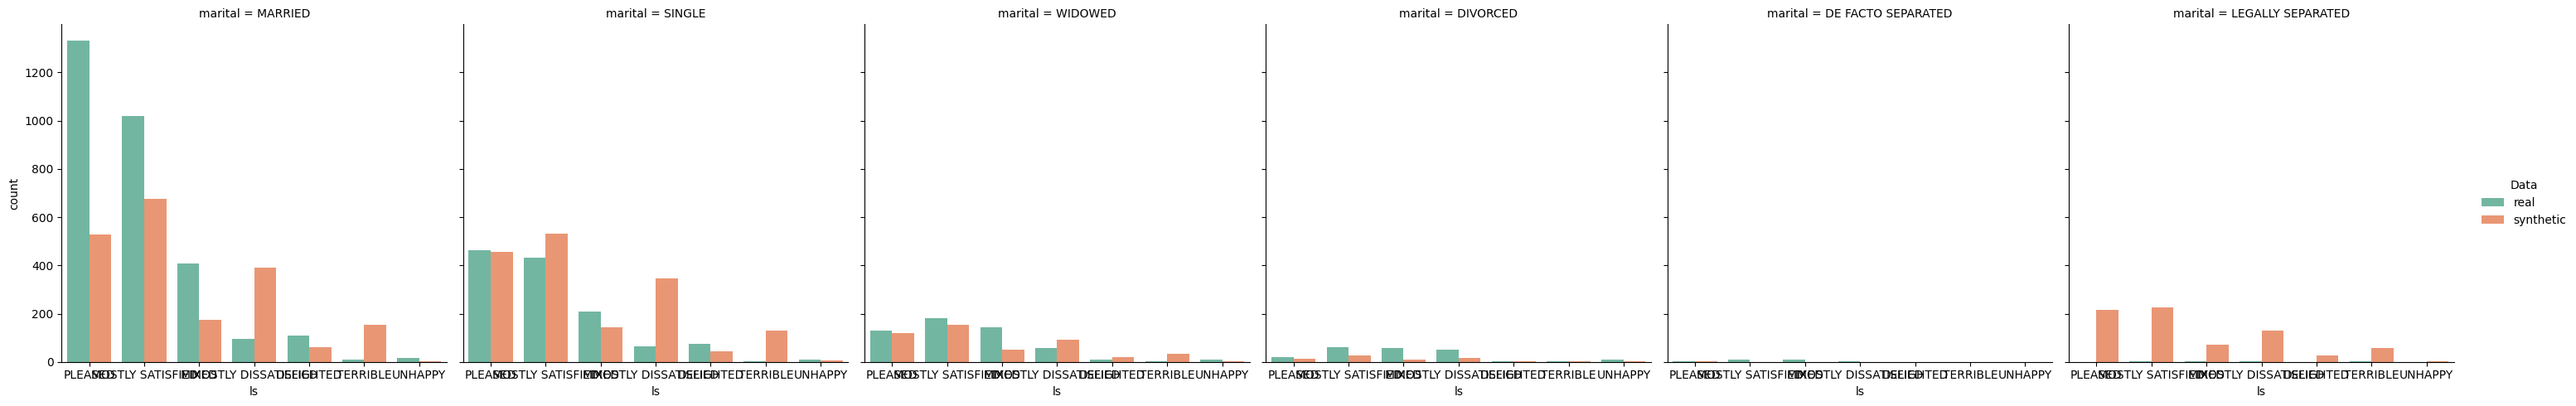

<Figure size 800x500 with 0 Axes>

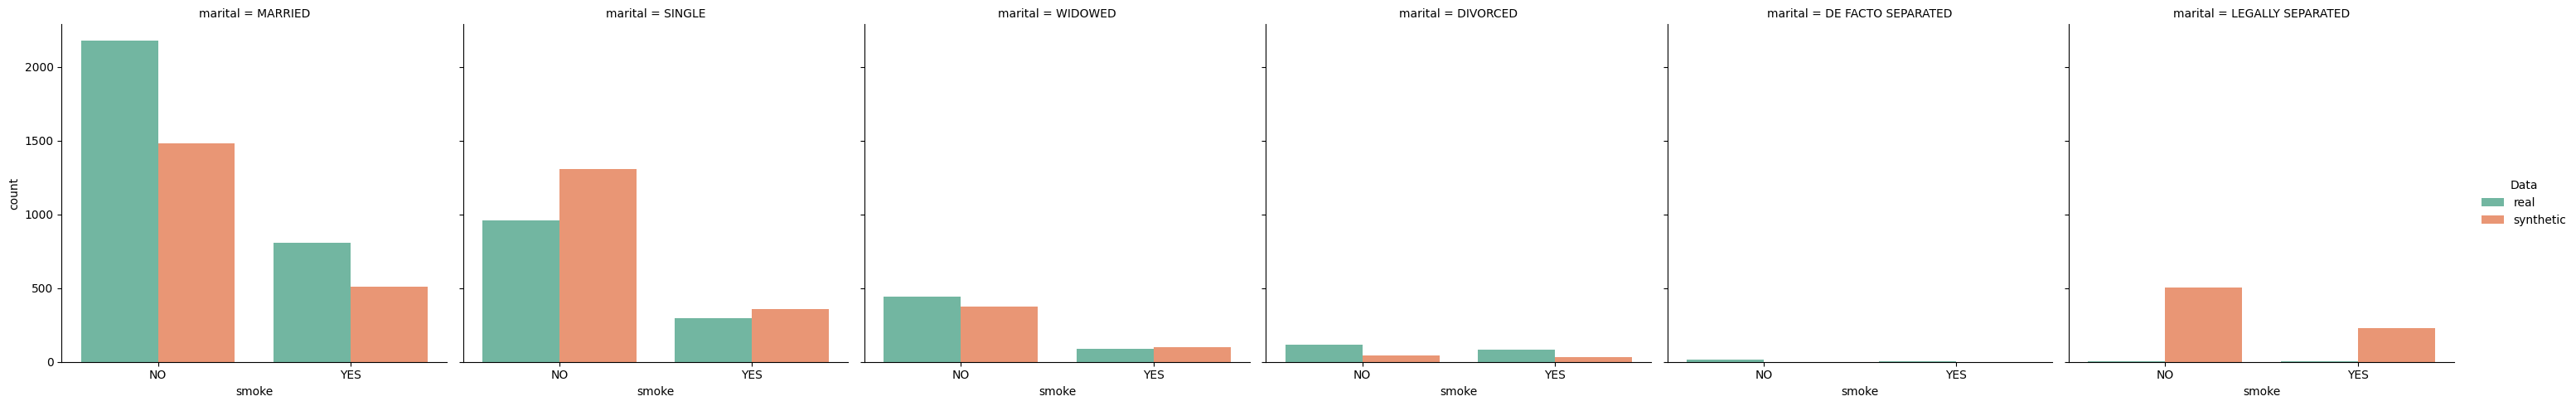

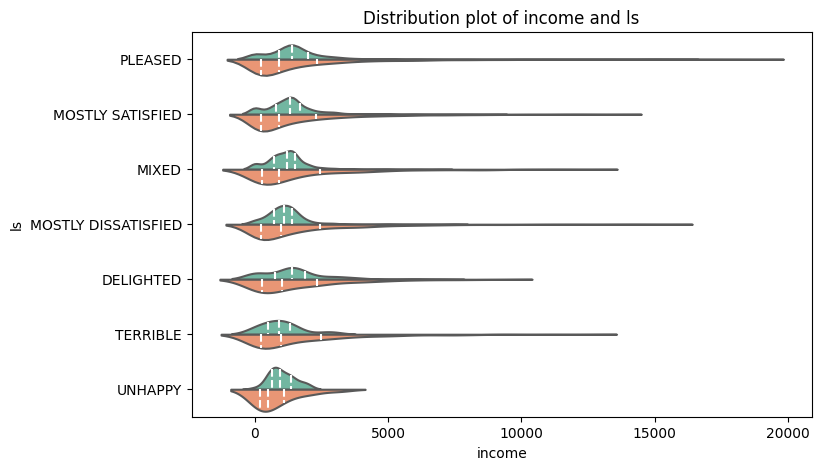

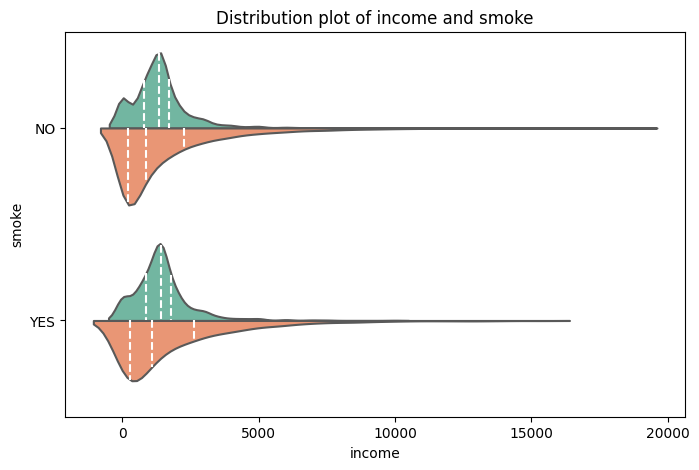

<Figure size 800x500 with 0 Axes>

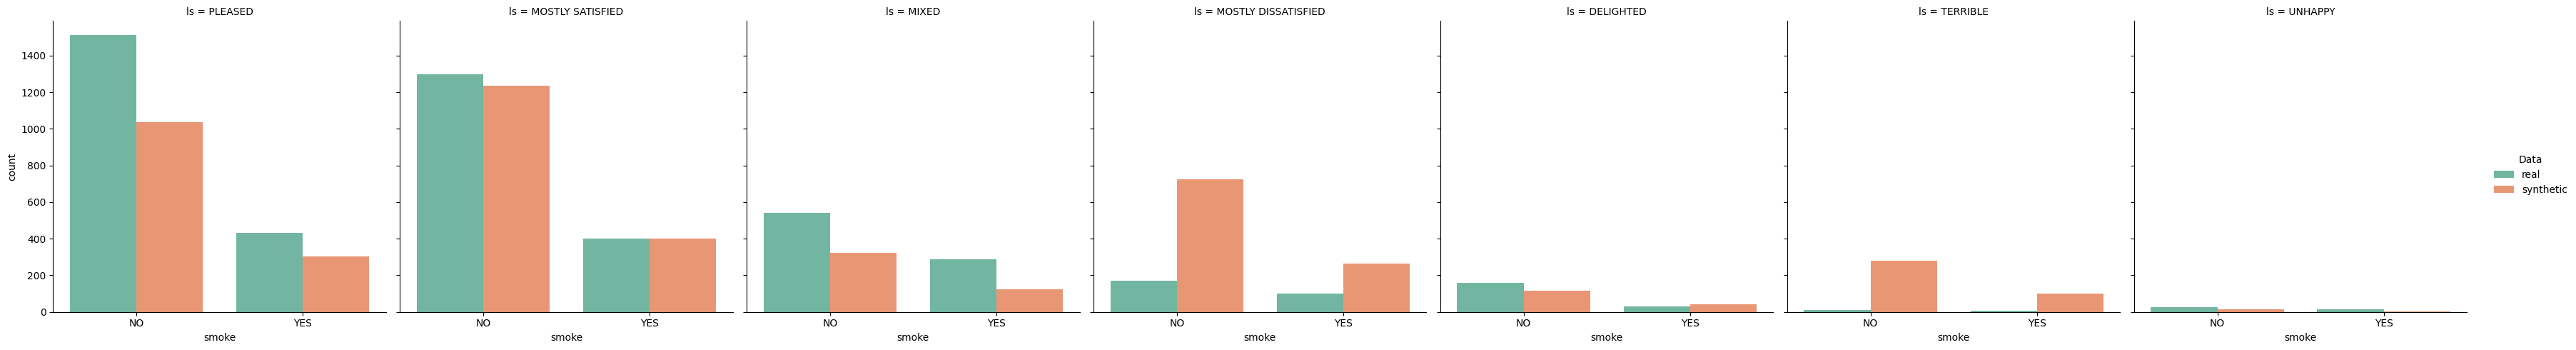

In [14]:
bivariate_plot(real_df, combined_data, column_dtypes, Comparison=True)

#### 4.2 Diagnostic report

##### 4.2.1 Diagnostic results

**UI text #6**

For each column, diagnostic results are computed for the quality of the generated synthetic data. The computed metrics depend on the type of data. 

- For numerical (or datetime) columns the following metrics are computed:
    * Missing value similarity [i] *Infobox*: Compares whether the synthetic data has the same proportion of missing values as the real data for a given column;
    * Range coverage [i] *Infobox*: Measures whether a synthetic column covers the full range of values that are present in a real column;
    * Boundary adherence [i] *Infobox*: Measures whether a synthetic column respects the minimum and maximum values of the real column. It returns the percentage of synthetic rows that adhere to the real boundaries;
    * Statistic similarity [i] *Infobox*: Measures the similarity between real column and a synthetic column by comparing the mean, standard deviation and median;
    * Kolmogorov–Smirnov (KS) complement [i] *Infobox*: Computes the similarity of a real and synthetic numerical column in terms of the column shapes, i.e., the marginal distribution or 1D histogram of the column.
- For categorical (or boolean) columns the following metrics are computed:
    * Missing value similarity [i] *Infobox*: Compares whether the synthetic data has the same proportion of missing values as the real data for a given column;
    * Category coverage [i] *Infobox*: Measures whether a synthetic column covers all the possible categories that are present in a real column;
    * Category adherence [i] *Infobox*: Measures whether a synthetic column adheres to the same category values as the real data;
    * Total variation (TV) complement [i] *Infobox*: Computes the similarity of a real and synthetic categorical column in terms of the column shapes, i.e., the marginal distribution or 1D histogram of the column.

💯 All values need to be close to 1.0 

In [15]:
# Instantiate and generate a diagnostic report
report = MetricsReport(real_df, synthetic_df, metadata)
report_df = report.generate_report()
print("=== Diagnostic Report ===")
display(report_df)

=== Diagnostic Report ===


,column,type,missing_value_similarity,range_coverage,boundary_adherence,ks_complement,tv_complement,statistic_similarity,category_coverage,category_adherence
0,sex,categorical,1.0000,N/A,N/A,N/A,0.6602,N/A,1.0,1.0
1,age,numerical,1.0000,0.987654,1.0,0.9338,N/A,0.964121,N/A,N/A
2,marital,categorical,0.9880,N/A,N/A,N/A,0.765965,N/A,1.0,1.0
3,income,numerical,1.0000,1.0,0.9998,0.7606,N/A,0.558888,N/A,N/A
4,ls,categorical,0.9922,N/A,N/A,N/A,0.782646,N/A,1.0,1.0
5,smoke,categorical,1.0000,N/A,N/A,N/A,0.9932,N/A,1.0,1.0


##### 4.2.2 Correlation matrix

**UI text #7**

The matrices below display the pairwise correlations in the original and synthetic data. Green cells represent weak pairwise correlations, while red cells denote strong pairwise correlations. The color patterns in the two matrices should appear identical.

In [16]:
metadata

{'sex': 'categorical',
 'age': 'numerical',
 'marital': 'categorical',
 'income': 'numerical',
 'ls': 'categorical',
 'smoke': 'categorical'}

In [17]:
# Convert categorical variables to numerical values
real_df_encoded = real_df.copy()
real_df_encoded['sex'] = real_df_encoded['sex'].astype('category').cat.codes
real_df_encoded['marital'] = real_df_encoded['marital'].astype('category').cat.codes
real_df_encoded['ls'] = real_df_encoded['ls'].astype('category').cat.codes
real_df_encoded['smoke'] = real_df_encoded['smoke'].astype('category').cat.codes

synth_df_encoded = synthetic_df.copy()
synth_df_encoded['sex'] = synth_df_encoded['sex'].astype('category').cat.codes
synth_df_encoded['marital'] = synth_df_encoded['marital'].astype('category').cat.codes
synth_df_encoded['ls'] = synth_df_encoded['ls'].astype('category').cat.codes
synth_df_encoded['smoke'] = synth_df_encoded['smoke'].astype('category').cat.codes

Text(0.5, 1.05, 'Absolute difference in correlation matrix, i.e., |real data - synthetic data|')

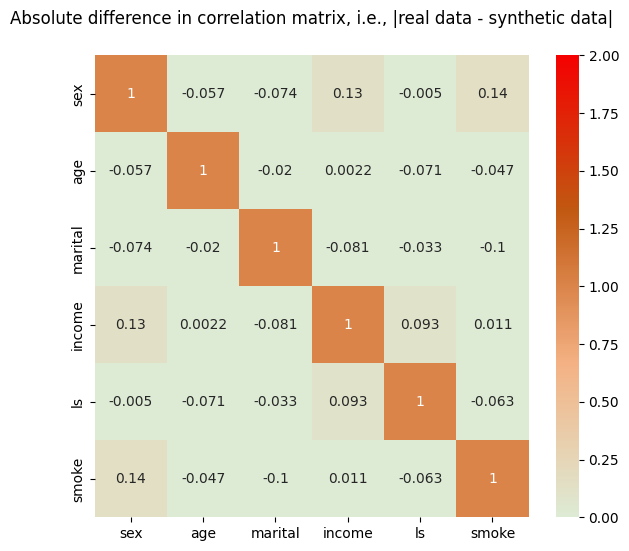

In [18]:
# Plot difference in correlation matrix between attached data and synthetic data
plt.figure(figsize=(7, 6))

# Define custom colormap
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#ddebd5', '#f4b183', '#c15811', '#f50101'])

# Plot correlation matrix for real_data
sns.heatmap(real_df_encoded.corr(), annot=True, cmap=cmap, vmin=0, vmax=2)
plt.title('Absolute difference in correlation matrix, i.e., |real data - synthetic data|', y=1.05)

Text(0.5, 1.05, 'Absolute difference in correlation matrix, i.e., |real data - synthetic data|')

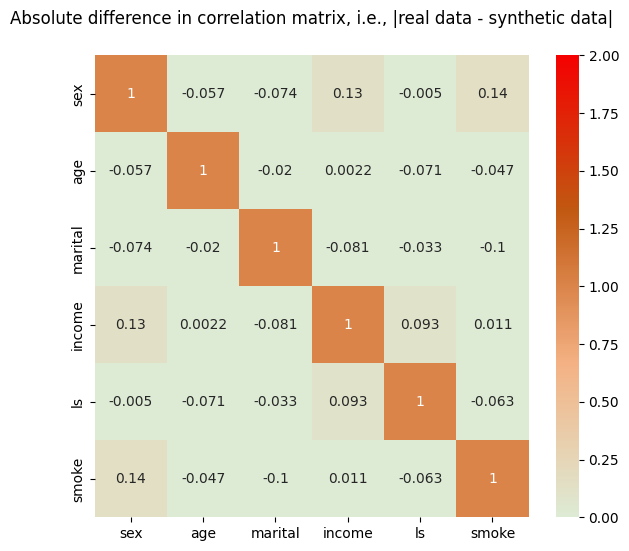

In [19]:
# Plot difference in correlation matrix between attached data and synthetic data
plt.figure(figsize=(7, 6))

# Define custom colormap
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#ddebd5', '#f4b183', '#c15811', '#f50101'])

# Plot correlation matrix for real_data
sns.heatmap(real_df_encoded.corr(), annot=True, cmap=cmap, vmin=0, vmax=2)
plt.title('Absolute difference in correlation matrix, i.e., |real data - synthetic data|', y=1.05)

##### 4.2.3 Efficacy metrics (regression and classification)

**UI text #8**
Efficacy metrics comparing real and synthetic datasets for downstream predictive tasks. The idea is to train a predictive model on synthetic data and evaluate its performance on real data. The type of metrics computed depends on the task:
    
- For regression (when the target is numerical):
    * Mean Squared Error (MSE)
    * Mean Absolute Error (MAE)
    * R^2 Score
    
- For classification (when the target is categorical/boolean):
    * Accuracy Score
    * Weighted F1 Score

In [20]:
# select first numerical column as target column
first_numerical = next(col for col, dtype in column_dtypes.items() if dtype == 'numerical')
reg_efficacy = EfficacyMetrics(task='regression', target_column=first_numerical)
reg_metrics = reg_efficacy.evaluate(real_df, synthetic_df)
print("=== Regression efficacy metrics ===")
print(reg_metrics)

=== Regression efficacy metrics ===
{'mse': 345.1392181871939, 'mae': 15.818538917164997, 'r2': -0.0072442397493595045}


In [21]:
# select first categorical column as target column
first_categorical = next(col for col, dtype in column_dtypes.items() if dtype == 'categorical')
clf_efficacy = EfficacyMetrics(task='classification', target_column=first_categorical)
clf_metrics = clf_efficacy.evaluate(real_df, synthetic_df)
print("\n=== Classification efficacy metrics ===")
print(clf_metrics)


=== Classification efficacy metrics ===
{'accuracy': 0.542, 'f1_score': 0.453967080736786}


##### 4.2.4 Privacy metrics

**UI text #9**
A class to compute the disclosure protection metric for synthetic data. This metric measures the proportion of synthetic records that are too similar (within a defined threshold) to real records, posing a disclosure risk.

In [22]:
dp = DisclosureProtection(real_df, synthetic_df)
dp_score = dp.score()
dp_report = dp.report()

print("\n=== Disclosure Protection ===")
print(f"Score: {dp_score:.3f}")
print("Detailed Report:", dp_report)


=== Disclosure Protection ===
Score: 1.000
Detailed Report: {'threshold': 0.0, 'risk_rate': 0.0, 'disclosure_protection_score': 1.0}


### 5. Generated synthetic data

[tabel] + download

### 6. More information

**UI text #9**

Do you want to learn more about synthetic data?
- Source code of this tool:
    - [python-synthpop](https://github.com/NGO-Algorithm-Audit/python-synthpop)
    - [local-first web app](https://github.com/NGO-Algorithm-Audit/local-first-web-tool/tree/main) 
- [Synthetic Data: what, why and how?](https://royalsociety.org/-/media/policy/projects/privacy-enhancing-technologies/Synthetic_Data_Survey-24.pdf)
- [Knowledge Network Synthetic Data](https://online.rijksinnovatiecommunity.nl/groups/399-kennisnetwerk-synthetischedata/welcome) (for Dutch public organizations)
- [Synthetic data portal of Dutch Executive Agency for Education](https://duo.nl/open_onderwijsdata/footer/synthetische-data.jsp) (DUO)
- [CART: synthpop resources](https://synthpop.org.uk/resources.html)
- [Gaussian Copula - Synthetic Data Vault](https://docs.sdv.dev/sdv)
